In [4]:
import pandas as pd
import numpy as np

import torch
from transformers import BertTokenizer, BertConfig, BertModel

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
from dataset import RelationsDS

data = RelationsDS(root="./data").to(device=device)
data[0]

Data(edge_index=[2, 111276], edge_attr=[111276], token_ids=[91294, 147], token_mask=[91294, 147], token_type_ids=[91294, 147])

# BERT encoder

In [10]:
from torch.utils.data import DataLoader

g = data[0].to(device)
tokens = torch.stack([g.token_ids, g.token_mask, g.token_type_ids], dim=1)
tokens.shape

torch.Size([91294, 3, 147])

In [11]:
model = BertModel.from_pretrained("bert-base-uncased").to(device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [36]:
91294 / 2, 45647 / 7

(45647.0, 6521.0)

In [15]:
tokens.shape

torch.Size([91294, 3, 147])

In [19]:
batch_size = 1024
token_loader = DataLoader(tokens, batch_size=batch_size)

encoding_size = 768
x = None

with torch.no_grad():
    for batch_num, token_batch in enumerate(token_loader):
        if batch_num % 10 * batch_size == 0:
            print(f"batch {batch_num}/{len(token_loader)}")
        batch_encoding = model(
            token_batch[:, 0, :], token_batch[:, 1, :], token_batch[:, 2, :]
        ).last_hidden_state[:, 0, :]
        if x is None:
            x = batch_encoding
        else:
            x = torch.concat([x, batch_encoding])

batch 0/90
batch 10/90
batch 20/90
batch 30/90
batch 40/90
batch 50/90
batch 60/90
batch 70/90
batch 80/90


In [20]:
x.shape

torch.Size([91294, 768])

In [7]:
with torch.no_grad():
    idx = 0
    id = g.token_ids[idx].unsqueeze(0)
    mask = g.token_mask[idx].unsqueeze(0)
    type_ids = g.token_type_ids[idx].unsqueeze(0)
    print(id.shape, mask.shape, type_ids.shape)

    encoding = model(id, mask, type_ids)

torch.Size([1, 138]) torch.Size([1, 138]) torch.Size([1, 138])


In [5]:
with torch.no_grad():
    num = 10
    id = g.token_ids[:num]
    mask = g.token_mask[:num]
    type_ids = g.token_type_ids[:num]
    print(id.shape, mask.shape, type_ids.shape)

    encoding = model(id, mask, type_ids)

torch.Size([10, 138]) torch.Size([10, 138]) torch.Size([10, 138])


In [10]:
lhs = encoding.last_hidden_state
lhs = lhs[:, 0, :]
lhs = lhs.flatten(start_dim=1)
print(lhs.shape, type(lhs))
print(lhs.mean(), lhs.std())

torch.Size([10, 768]) <class 'torch.Tensor'>
tensor(-0.0102, device='cuda:0') tensor(0.5358, device='cuda:0')


# Model

adapted from [Online Link Prediction with Graph Neural Networks](https://medium.com/stanford-cs224w/online-link-prediction-with-graph-neural-networks-46c1054f2aa4)

In [14]:
from model import Model, LinkPredictor, NodeEmbedder
import torch
from torch.nn import functional as F

In [2]:
from dataset import WN18RR

data = WN18RR(root="./data/wn18rr")
g = data[0]
g.edge_attr = F.one_hot(g.edge_attr, num_classes=12).float().squeeze(1)

Processing...
Done!


In [15]:
device = "cpu"
g = g.to(device)

node_embedder = NodeEmbedder(
    input_dim=768, hidden_dim=256, output_dim=256, edge_dim=12, num_heads=1, num_layers=2
).to(device)

link_pred = LinkPredictor(
    input_dim=256, hidden_dim=128, output_dim=1, edge_dim=12, num_layers=3
).to(device)

model = Model(node_embedder, link_pred)

In [5]:
emb = node_embedder(g.x, g.edge_index, g.edge_attr)

In [6]:
batch = [1,4,8]
edge_index = g.edge_index[:, batch]
xr = g.edge_attr[batch]
xs = emb[edge_index[0]]
xo = emb[edge_index[1]]

# link_pred(xs, xr, xo)

In [7]:
link_pred(xs, xr, xo)

tensor([[-0.0201],
        [-0.7071],
        [ 0.6641]], grad_fn=<AddmmBackward0>)

# Train procedure

In [1]:
from model import Model, LinkPredictor, NodeEmbedder
import torch
from torch.nn import functional as F

node_embedder = NodeEmbedder(
    input_dim=768, hidden_dim=256, output_dim=256, edge_dim=12, num_heads=1, num_layers=2
)

link_pred = LinkPredictor(
    input_dim=256, hidden_dim=128, output_dim=1, edge_dim=12, num_layers=3
)

model = Model(node_embedder, link_pred)

/home/julia/miniconda3/envs/nlp/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
from dataset import WN18RR
from torch_geometric.utils import remove_self_loops, contains_self_loops, structured_negative_sampling
from torch.utils.data import TensorDataset

data = WN18RR(root="./data/wn18rr")
g = data[0]
g.edge_attr = F.one_hot(g.edge_attr, 12).float().squeeze(1)

target_edges, target_attrs = remove_self_loops(g.edge_index, g.edge_attr)
target_labels = torch.ones(target_edges.shape[1], dtype=torch.float)

i, _, k = structured_negative_sampling(target_edges, g.num_nodes, contains_neg_self_loops=False)
negative_edges = torch.stack([i,k])

target_edges = torch.cat([target_edges, negative_edges], dim=1)
target_attrs = target_attrs.repeat(2, 1)
target_labels = torch.cat([target_labels, torch.zeros_like(target_labels)])

targets = TensorDataset(target_edges.T, target_attrs, target_labels)

Processing...
Done!


In [3]:
from torch.utils.data import DataLoader
loader = DataLoader(targets, batch_size=10)
for e, a, l in loader:
    print(e.T.shape, a.shape, l)
    model(g.x, g.edge_index, g.edge_attr, e.T, a)
    break

torch.Size([2, 10]) torch.Size([10, 12]) tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [4]:
from train import train
from torch.optim import Adam

optimizer = Adam(model.parameters())

mean_loss = train(model, optimizer, g, targets, batch_size=1024)

KeyboardInterrupt: 

# Evaluations

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
)
from sklearn.preprocessing import binarize
import torch
import torch.nn.functional as F

In [32]:
experiment = "final1"
res = pd.read_csv(f"{experiment}-results.csv")
res["y_pred"] = np.argmax(res[["y_pred_neg", "y_pred_hyp", "y_pred_hol"]], axis=1)
res[["y_pred_neg_u", "y_pred_hyp_u", "y_pred_hol_u"]] = res[
    ["y_pred_neg", "y_pred_hyp", "y_pred_hol"]
]
res[["y_pred_neg", "y_pred_hyp", "y_pred_hol"]] = res[
    ["y_pred_neg", "y_pred_hyp", "y_pred_hol"]
].apply(
    lambda p: torch.softmax(torch.tensor(p.to_numpy()), dim=0).numpy(),
    axis=1,
    result_type="expand",
)
res.head()

,Unnamed: 0,y_true,y_pred_neg,y_pred_hyp,y_pred_hol,y_pred,y_pred_neg_u,y_pred_hyp_u,y_pred_hol_u
0,0,1,0.000816,0.980975,0.018208,1,-3.339874,3.751513,-0.235151
1,1,1,0.001391,0.968139,0.030470,1,-3.196710,3.348395,-0.110240
2,2,1,0.002252,0.975807,0.021941,1,-2.810284,3.261282,-0.533631
3,3,2,0.066813,0.017859,0.915327,2,-0.263190,-1.582563,2.354189
4,4,1,0.001446,0.974539,0.024016,1,-3.093001,3.420441,-0.282821


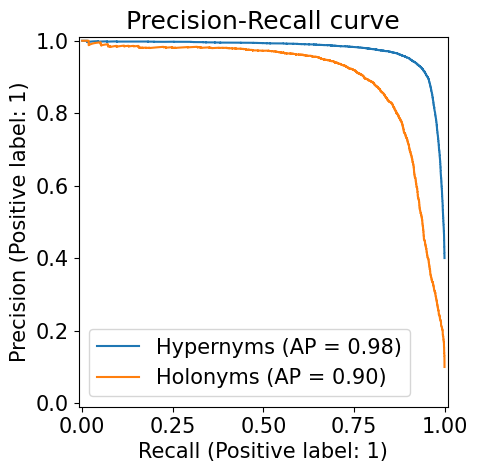

In [9]:
_, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    res["y_true"] == 1, res["y_pred_hyp"], name="Hypernyms", ax=ax
)
PrecisionRecallDisplay.from_predictions(
    res["y_true"] == 2, res["y_pred_hol"], name="Holonyms", ax=ax
)
plt.title("Precision-Recall curve")
plt.savefig("imgs/pr.png", bbox_inches="tight")
plt.show()

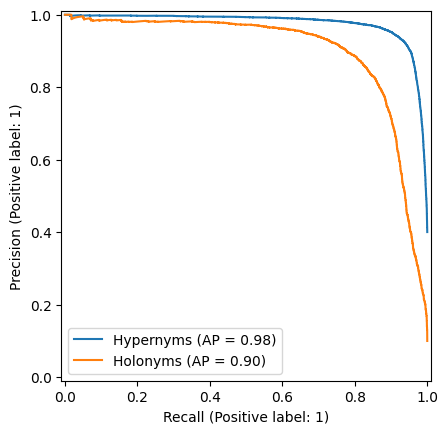

In [3]:
_, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    res["y_true"] == 1, res["y_pred_hyp"], name="Hypernyms", ax=ax
)
PrecisionRecallDisplay.from_predictions(
    res["y_true"] == 2, res["y_pred_hol"], name="Holonyms", ax=ax
)
plt.show()

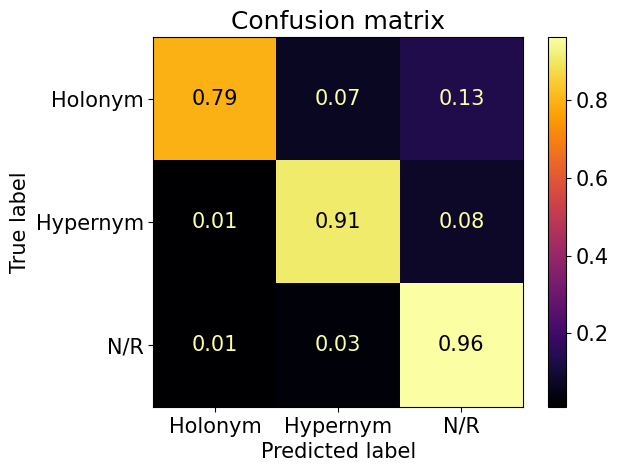

In [10]:
name_map = {0: "N/R", 1: "Hypernym", 2: "Holonym"}
ConfusionMatrixDisplay.from_predictions(
    res["y_true"].map(name_map),
    res["y_pred"].map(name_map),
    cmap="inferno",
    values_format=".2f",
    normalize="true",
)
plt.title("Confusion matrix")
plt.savefig("imgs/cm.png", bbox_inches="tight")
plt.show()

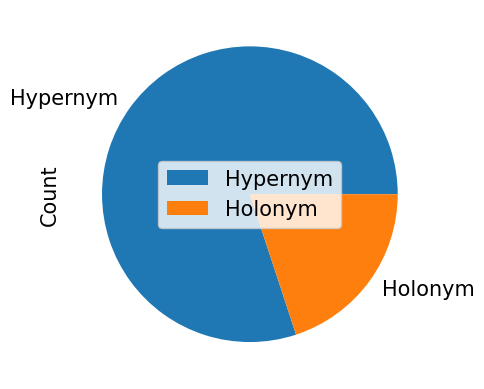

In [11]:
class_distribution = pd.DataFrame(
    {
        "lab": ["Hypernym", "Holonym"],
        "Count": [(res["y_true"] == 1).sum(), (res["y_true"] == 2).sum()],
    }
)
class_distribution = class_distribution.set_index("lab")
class_distribution.plot.pie(y="Count")
plt.show()

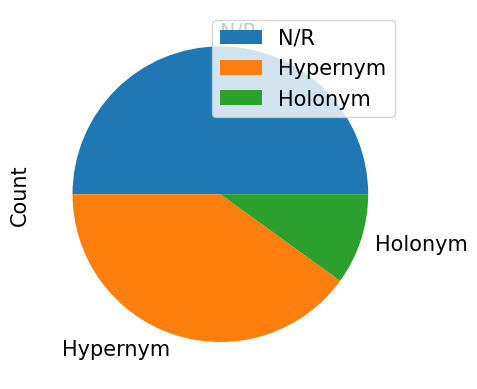

In [12]:
class_distribution = pd.DataFrame(
    {
        "lab": ["N/R", "Hypernym", "Holonym"],
        "Count": [
            (res["y_true"] == 0).sum(),
            (res["y_true"] == 1).sum(),
            (res["y_true"] == 2).sum(),
        ],
    }
)
class_distribution = class_distribution.set_index("lab")
class_distribution.plot.pie(y="Count")
plt.show()

In [33]:
preds = res[["y_pred_neg_u", "y_pred_hyp_u", "y_pred_hol_u"]]
preds = torch.tensor(preds.to_numpy(), dtype=torch.float)
labels = torch.tensor(res["y_true"])

with torch.no_grad():
    loss = F.cross_entropy(preds, labels)
loss

tensor(0.2665)

In [5]:
def precision_recall_f1(res, label):
    y_true = res["y_true"] == label
    pred = res["y_pred"] == label
    precision = precision_score(y_true, pred)
    recall = recall_score(y_true, pred)
    f1 = f1_score(y_true, pred)
    return precision, recall, f1


ps, rs, f1s = [], [], []
p, r, f1 = precision_recall_f1(res, 1)
ps.append(p)
rs.append(r)
f1s.append(f1)
print(f"Hypernyms: precision {p}, recall {r}, f1 {f1}")

p, r, f1 = precision_recall_f1(res, 2)
ps.append(p)
rs.append(r)
f1s.append(f1)
print(f"Holonyms: precision {p}, recall {r}, f1 {f1}")

p = precision_score(res["y_true"], res["y_pred"], average="macro", labels=[1, 2])
r = recall_score(res["y_true"], res["y_pred"], average="macro", labels=[1, 2])
f1 = f1_score(res["y_true"], res["y_pred"], average="macro", labels=[1, 2])
ps.append(p)
rs.append(r)
f1s.append(f1)
acc = accuracy_score(res["y_true"], res["y_pred"])
print(f"Macro: precision {p}, recall {r}, f1 {f1}")
print(f"Accuracy: {acc}")

latex_tab = pd.DataFrame(
    {
        " ": ["Hypernyms", "Holonyms", "Macro", "Accuracy"],
        "Precision": ps + [acc],
        "Recall": rs + [np.nan],
        "F1-measure": f1s + [np.nan],
    }
)

latex_tab

Hypernyms: precision 0.9464150061356863, recall 0.9089684588618251, f1 0.9273138472989608
Holonyms: precision 0.8866264454499748, recall 0.7947273546642631, f1 0.8381653992395437
Macro: precision 0.9165207257928305, recall 0.8518479067630441, f1 0.8827396232692523
Accuracy: 0.924357476635514


,,Precision,Recall,F1-measure
0,Hypernyms,0.946415,0.908968,0.927314
1,Holonyms,0.886626,0.794727,0.838165
2,Macro,0.916521,0.851848,0.882740
3,Accuracy,0.924357,NaN,NaN


In [ ]:
F.cross_entropy()

In [34]:
base = "multiclass15"
max_cont = 1
experiments = [f"{base}"] + [f"{base}_cont{n}" for n in range(1, max_cont + 1)]
experiments = None
if experiments is None:
    train = pd.read_csv(f"{experiment}-train_losses.csv")
else:
    train = pd.read_csv(f"{experiments[0]}-train_losses.csv")
    for exp in experiments[1:]:
        partial = pd.read_csv(f"{exp}-train_losses.csv")
        partial["epoch"] = partial["epoch"] + train["epoch"].tail(1).item()
        epoch = np.concatenate([train["epoch"], partial["epoch"]])
        train_loss = np.concatenate([train["train loss"], partial["train loss"]])
        val_loss = np.concatenate([train["val loss"], partial["val loss"]])
        train = pd.DataFrame(
            {"epoch": epoch, "train loss": train_loss, "val loss": val_loss}
        )
train

,Unnamed: 0,epoch,train loss,val loss
0,0,0,1.184071,1.084808
1,1,1,1.152488,1.085244
2,2,2,1.124239,1.085589
3,3,3,1.103392,1.085207
4,4,4,1.080340,1.084454
...,...,...,...,...
595,595,595,0.074698,0.277638
596,596,596,0.073706,0.278441
597,597,597,0.074109,0.278463
598,598,598,0.074676,0.276403


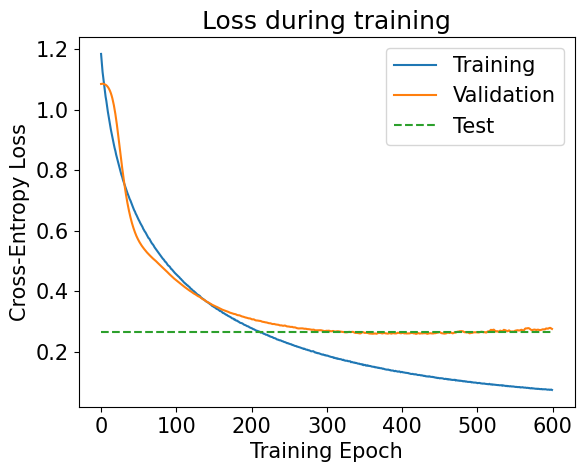

In [35]:
plt.plot(train["epoch"], train["train loss"], label="Training")
plt.plot(train["epoch"], train["val loss"], label="Validation")
# plt.vlines([190], 0.15, 1.1, linestyles='--')
plt.plot(train["epoch"], 0.2665 * np.ones(len(train["epoch"])), "--", label="Test")
# plt.plot(train['epoch'], 0.20*np.ones(len(train['epoch'])), '--')
plt.xlabel("Training Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Loss during training")
plt.legend()
plt.savefig("imgs/training.png", bbox_inches="tight")
plt.show()

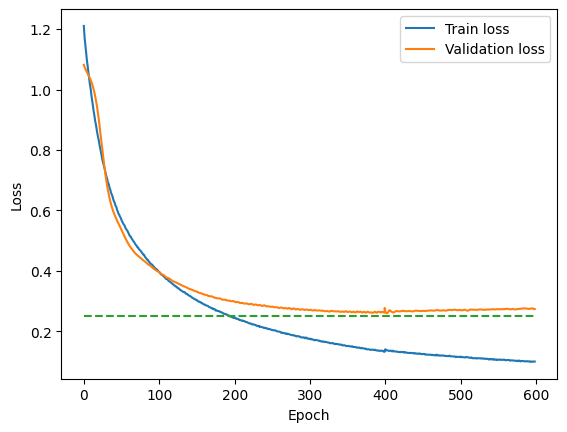

In [28]:
plt.plot(train["epoch"], train["train loss"], label="Train loss")
plt.plot(train["epoch"], train["val loss"], label="Validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train["epoch"], 0.25 * np.ones(len(train["epoch"])), "--")
# plt.plot(train['epoch'], 0.20*np.ones(len(train['epoch'])), '--')
# plt.vlines([ 170], 0.21, 1.1)
plt.show()

## Qualitative evaluation

In [3]:
from dataset import RelationsDS
from model import NodeEmbedder, LinkPredictor, Model
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import IPython.display

import pandas as pd
import numpy as np

pd.set_option("display.max_colwidth", None)

In [4]:
device = "cpu"
data = RelationsDS(root="./data").to(device)
g = data[0]

In [5]:
experiment = "final1-links"
res = pd.read_csv(f"{experiment}-results.csv")
res = res.drop("Unnamed: 0", axis=1)
res["y_pred"] = np.argmax(res[["y_pred_neg", "y_pred_hyp", "y_pred_hol"]], axis=1)
res[["y_pred_neg", "y_pred_hyp", "y_pred_hol"]] = res[
    ["y_pred_neg", "y_pred_hyp", "y_pred_hol"]
].apply(
    lambda p: torch.softmax(torch.tensor(p.to_numpy()), dim=0).numpy(),
    axis=1,
    result_type="expand",
)
res.head()

,y_true,y_pred_neg,y_pred_hyp,y_pred_hol,edge_i,edge_j,y_pred
0,1,0.000816,0.980975,0.018208,84008,91017,1
1,1,0.001391,0.968139,0.030470,21024,20846,1
2,1,0.002252,0.975807,0.021941,86657,90963,1
3,2,0.066813,0.017859,0.915327,9162,9161,2
4,1,0.001446,0.974539,0.024016,71567,71556,1


In [16]:
def _compose_definition(arg):
    import re

    id, definition = arg
    clean_id = re.sub(r"\..\.[0-9][0-9]", "", id)
    clean_id = re.sub(r"_", " ", clean_id)

    new_def = f"the definition of {clean_id} is {definition}"
    return new_def


defs = pd.read_csv("data/direct_relations.csv")
all_ids = pd.concat([defs["ID_Synset"], defs["ID_Relacionada"]])
all_definitions = pd.concat([defs["Definição_Synset"], defs["Definição_Relacionada"]])

entities = pd.DataFrame({"ID": all_ids, "Definição": all_definitions}).drop_duplicates()
definitions = entities.apply(_compose_definition, axis=1)
mapping = lambda idx: definitions.iloc[idx]
definitions

0                                             the definition of physical entity is an entity that has physical existence
1         the definition of abstraction is a general concept formed by extracting common features from specific examples
2                                                        the definition of thing is a separate and self-contained entity
3                            the definition of object is a tangible and visible entity; an entity that can cast a shadow
4                                  the definition of whole is an assemblage of parts that is regarded as a single entity
                                                               ...                                                      
111129            the definition of range is have a range; be capable of projecting over a certain distance, as of a gun
111207                                                                 the definition of precipitate is fall from clouds
111221                          

In [17]:
res["definition"] = res["edge_i"].map(mapping)
res["related_definition"] = res["edge_j"].map(mapping)
res = res.drop(["edge_i", "edge_j"], axis=1)
incorrect = res[res["y_true"] != res["y_pred"]]
incorrect_hyp = incorrect[incorrect["y_true"] == 1]
incorrect_hol = incorrect[incorrect["y_true"] == 2]
incorrect_neg = incorrect[incorrect["y_true"] == 0]

In [18]:
incorrect_hol.sample(10)

,y_true,y_pred_neg,y_pred_hyp,y_pred_hol,y_pred,definition,related_definition
18803,2,0.949791,0.004974,0.045235,0,the definition of handle is the appendage to an object that is designed to be held in order to use or move it,the definition of teacup is a cup from which tea is drunk
21608,2,0.740311,0.129469,0.130220,0,the definition of ramanavami is Hindu lunar holiday (on the 9th day of Caitra) to celebrate the birth of Rama,the definition of chait is the first Hindu calendar month (corresponding to March in the Gregorian calendar)
20319,2,0.024926,0.917791,0.057283,1,the definition of chalk is a soft whitish calcite,"the definition of chalk is a piece of calcite or a similar substance, usually in the shape of a crayon, that is used to write or draw on blackboards or other flat surfaces"
12937,2,0.932211,0.006638,0.061151,0,the definition of candelilla wax is a hard brown wax that occurs as a coating on candelilla shrubs,the definition of candelilla is wax-coated shrub of northern Mexico and southwestern United States
1650,2,0.878103,0.009287,0.112609,0,the definition of longan is tree of southeastern Asia to Australia grown primarily for its sweet edible fruit resembling litchi nuts; sometimes placed in genera Euphorbia or Nephelium,the definition of dimocarpus is longan
15443,2,0.928323,0.006022,0.065655,0,the definition of banana is elongated crescent-shaped yellow fruit with soft sweet flesh,the definition of dwarf banana is low-growing Asian banana tree cultivated especially in the West Indies for its clusters of edible yellow fruit
1125,2,0.003492,0.955009,0.041499,1,the definition of porterhouse is large steak from the thick end of the short loin containing a T-shaped bone and large piece of tenderloin,the definition of beef loin is cut of meat from a loin of beef
20698,2,0.002201,0.941085,0.056714,1,the definition of golgi body is a netlike structure in the cytoplasm of animal cells (especially in those cells that produce secretions),the definition of cytoplasm is the protoplasm of a cell excluding the nucleus; is full of proteins that control cell metabolism
1127,2,0.719173,0.027050,0.253778,0,the definition of limb is the graduated arc that is attached to an instrument for measuring angles,the definition of sextant is a measuring instrument for measuring the angular distance between celestial objects; resembles an octant
16751,2,0.915875,0.007963,0.076162,0,the definition of rabbitwood is shrub of southeastern United States parasitic on roots of hemlocks having sparse spikes of greenish flowers and pulpy drupes,the definition of pyrularia is small genus of chiefly Asiatic parasitic shrubs


In [55]:
incorrect_hyp.sample(10)

,y_true,y_pred_neg,y_pred_hyp,y_pred_hol,y_pred,definition,related_definition
7322,1,0.898313,0.045045,0.056643,0,the definition of quotient verdict is an improper and unacceptable kind of compromise verdict,the definition of compromise verdict is a verdict resulting from improper compromises between jurors on material issues
3838,1,0.730572,0.217832,0.051596,0,the definition of dphil is a British doctorate,the definition of doctor of philosophy is a doctorate awarded for original contributions to knowledge
4019,1,0.911294,0.013056,0.075650,0,the definition of bone china is fine porcelain that contains bone ash,the definition of china is high quality porcelain originally made only in China
6587,1,0.522867,0.257072,0.220061,0,the definition of st.-bruno's-lily is a variety of spiderwort,the definition of spiderwort is any plant of the family Commelinaceae
6833,1,0.008453,0.294957,0.696591,2,the definition of bar line is a vertical line before the accented beat marking the boundary between musical bars,the definition of musical notation is (music) notation used by musicians
14997,1,0.910630,0.052456,0.036915,0,the definition of reentry is the act of entering again,the definition of return is the act of going back to a prior location
21087,1,0.967339,0.008670,0.023991,0,the definition of uniocular dichromat is a person who has normal vision in one eye and dichromacy in the other; very rare but very useful for experiments on color vision,the definition of dichromat is a person with any of the various forms of dichromacy
7723,1,0.956767,0.011410,0.031823,0,the definition of ethic is the principles of right and wrong that are accepted by an individual or a social group,the definition of principle is a rule or standard especially of good behavior
19243,1,0.838461,0.113541,0.047998,0,the definition of footing is a relation that provides the foundation for something,the definition of foundation is the basis on which something is grounded
2103,1,0.469669,0.459281,0.071050,0,the definition of drop is fall or sink into a state of exhaustion or death,the definition of fall is pass suddenly and passively into a state of body or mind


In [20]:
incorrect_neg.sample(10)

,y_true,y_pred_neg,y_pred_hyp,y_pred_hol,y_pred,definition,related_definition
31877,0,0.175134,0.045470,0.779396,2,the definition of kung fu is a Chinese martial art,the definition of ontario is a prosperous and industrialized province in central Canada
28058,0,0.003724,0.968873,0.027403,1,the definition of scaling is ascent by or as if by a ladder,the definition of accretion is an increase by natural growth or addition
40485,0,0.337792,0.537961,0.124247,1,the definition of leatherwork is work made of leather,the definition of surgical knife is a very sharp knife used in surgery
26231,0,0.401170,0.524682,0.074148,1,the definition of cleavage is the act of cleaving or splitting,the definition of vacuolization is the state of having become filled with vacuoles
34217,0,0.123588,0.799734,0.076678,1,the definition of genre painting is a genre depicting everyday life,the definition of whole is an assemblage of parts that is regarded as a single entity
26234,0,0.277399,0.633875,0.088726,1,the definition of crepe is paper with a crinkled texture; usually colored and used for decorations,the definition of butylene is any of three isomeric hydrocarbons C4H8; all used in making synthetic rubbers
41382,0,0.007509,0.041628,0.950863,2,the definition of grouper is flesh of a saltwater fish similar to sea bass,the definition of american crayfish is common large crayfishes of eastern North America
41044,0,0.262933,0.678530,0.058537,1,the definition of sign is mark with one's signature; write one's name (on),"the definition of flare up is ignite quickly and suddenly, especially after having died down"
38707,0,0.030862,0.875208,0.093930,1,the definition of man is the generic use of the word to refer to any human being,the definition of antitype is a person or thing represented or foreshadowed by a type or symbol; especially a figure in the Old Testament having a counterpart in the New Testament
30790,0,0.037943,0.907671,0.054386,1,the definition of bow leg is outward curvature of the legs,the definition of cut is the act of cutting something into parts
